In [1]:
from config.config import DB_CONFIG
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

# Check we have data

In [2]:
connection_string = (
    f"postgresql+psycopg2://{DB_CONFIG['user']}:{DB_CONFIG['password']}"
    f"@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
)
conn = create_engine(connection_string)

In [3]:
pd.read_sql_query("""
    SELECT *
    FROM countries
""", conn).T

,0,1
id,CR,VN
name,Costa Rica,Vietnam
total_production,86164791,1878000003
num_farmers,32899,615738
num_middlemen,165,1331
num_exporters,31,73
max_buyers_per_farmer,3,3
max_exporters_per_middleman,3,3
farmer_production_sigma,0.8,0.8
middleman_capacity_sigma,0.5,0.5


# Get data for a test country

In [4]:
COUNTRY = 'CR'

In [5]:
df_farmers = pd.read_sql_query(f"""
    SELECT *
    FROM farmers
    WHERE country_id = '{COUNTRY}'
""", conn)
df_farmers.tail()

,id,country_id,geography_id,num_plots,production_amount,loyalty
32827,CR_F_0032827,CR,cr_ssu_valverde_vega,1,2404.0,0.505051
32828,CR_F_0032828,CR,cr_ssu_valverde_vega,3,935.0,0.629937
32829,CR_F_0032829,CR,cr_ssu_valverde_vega,3,1641.0,0.268528
32830,CR_F_0032830,CR,cr_ssu_valverde_vega,3,698.0,0.453717
32831,CR_F_0032831,CR,cr_ssu_valverde_vega,1,474.0,0.197469


In [6]:
df_geos = pd.read_sql_query(f"""
    SELECT *
    FROM geographies
    WHERE country_id = '{COUNTRY}'
""", conn)
df_geos.tail()

,id,country_id,name,centroid,producing_area_name,num_farmers,total_production_kg,primary_crop
41,cr_ssu_tarrazu,CR,Tarrazú,"9.589,-84.052",cr_pa_los_santos,1600,13320059,arabica
42,cr_ssu_tilaran,CR,Tilarán,"10.483,-84.929",cr_pa_zona_norte,180,161942,arabica
43,cr_ssu_turrialba,CR,Turrialba,"9.824,-83.544",cr_pa_brunca_y_turrialba,1300,2197559,arabica
44,cr_ssu_turrubares,CR,Turrubares,"9.761,-84.509",cr_pa_valle_central,60,206857,arabica
45,cr_ssu_valverde_vega,CR,Valverde Vega,"10.185,-84.3",cr_pa_valle_occidental,620,1000502,arabica


In [7]:
df_trade = pd.read_sql_query(f"""
    SELECT *
    FROM trading_flows
    WHERE country_id = '{COUNTRY}'
""", conn)
df_trade.tail()

,year,country_id,farmer_id,middleman_id,exporter_id,sold_to_eu,amount_kg
425117,2,CR,CR_F_0032830,CR_M_00095,CR_E_00010,True,92
425118,2,CR,CR_F_0032830,CR_M_00123,CR_E_00027,False,401
425119,2,CR,CR_F_0032831,CR_M_00095,CR_E_00027,False,65
425120,2,CR,CR_F_0032831,CR_M_00095,CR_E_00010,False,162
425121,2,CR,CR_F_0032831,CR_M_00123,CR_E_00027,False,246


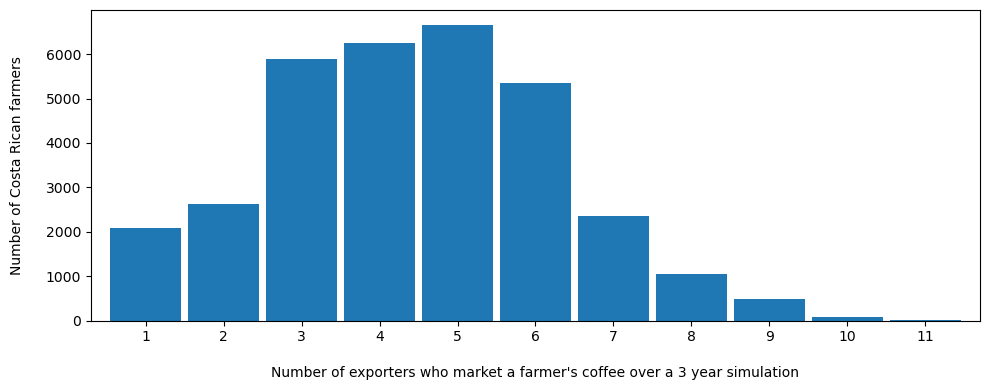

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
df_trade.groupby('farmer_id')['exporter_id'].nunique().value_counts().sort_index().plot(
    kind='bar',
    width=.9,
    ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel("\nNumber of exporters who market a farmer's coffee over a 3 year simulation")
ax.set_ylabel("Number of Costa Rican farmers\n")
plt.tight_layout()
plt.show()

# Visualize some of the data

In [29]:
def plot_kde(df, group_col, value_col, title, aggfunc='sum'):
    grouped = df.groupby(group_col)[value_col].agg(aggfunc)
    n = len(grouped)
    stats = {
        "avg (kg)": grouped.mean(),
        "std (kg)": grouped.std(),
        "min (kg)": grouped.min(),
        "median (kg)": grouped.median(),        
        "max (kg)": grouped.max(),
        "total (kg)": grouped.sum(),
    }
    plt.figure(figsize=(10, 3))
    sns.histplot(data=grouped, kde=True, stat="count", fill=True)
    plt.title(f"{title} (n={n:,.0f})")
    plt.xlim(0,)
    plt.xlabel("Values")
    plt.ylabel("")

    stats_text = "\n".join([f"{k}: {v:,.0f}" for k, v in stats.items()])
    plt.annotate(stats_text, xy=(0.95, 0.5), xycoords="axes fraction", ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

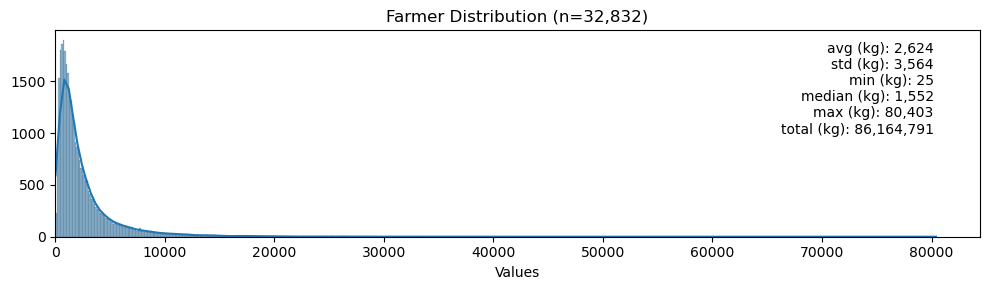

In [30]:
plot_kde(
    df_farmers,
    group_col='id',
    value_col='production_amount',
    title='Farmer Distribution'
)

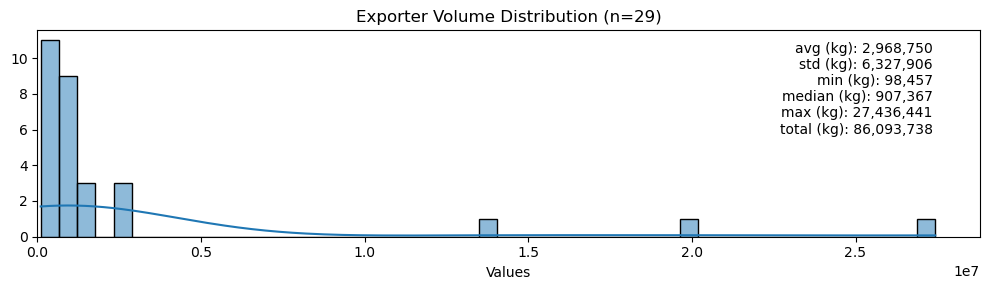

In [31]:
plot_kde(
    df_trade.query("year == 0"),
    group_col='exporter_id',
    value_col='amount_kg',
    title='Exporter Volume Distribution'
)

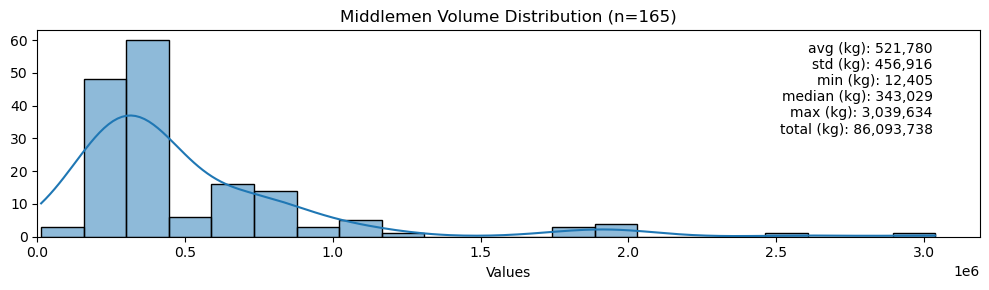

In [32]:
plot_kde(
    df_trade.query("year == 0"),
    group_col='middleman_id',
    value_col='amount_kg',
    title='Middlemen Volume Distribution'
)

<Axes: xlabel='middleman_id', ylabel='exporter_id'>

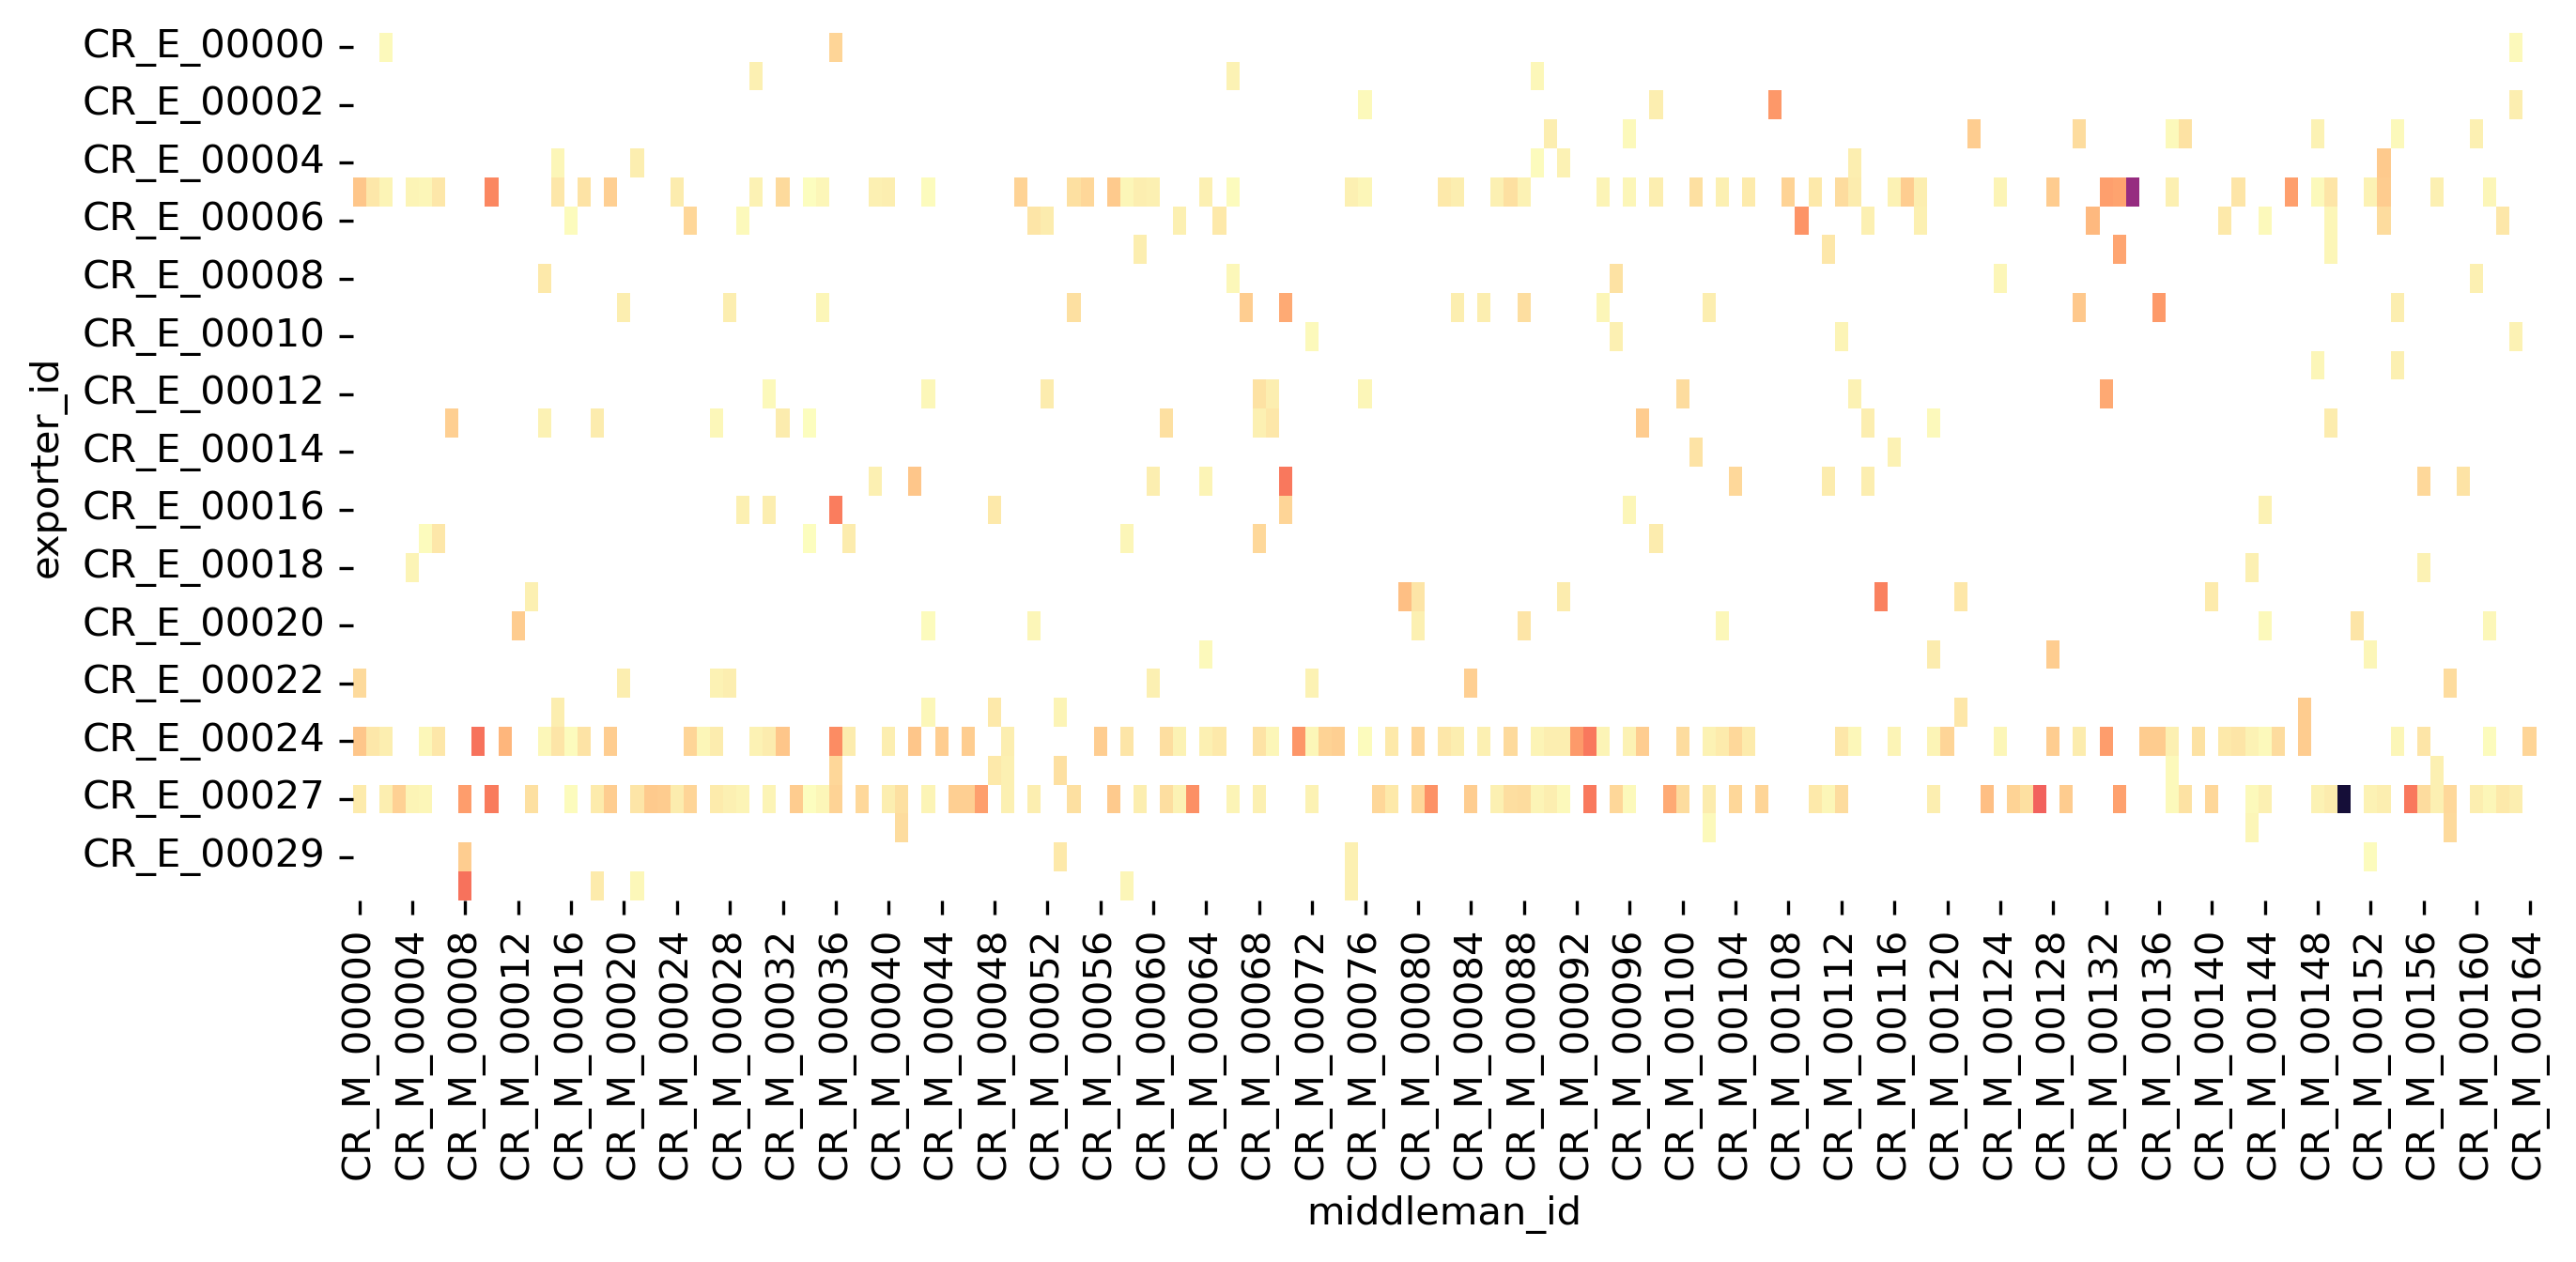

In [42]:
fig, ax = plt.subplots(figsize=(10,4), dpi=300)
sns.heatmap(df_trade.pivot_table(
    index='exporter_id',
    columns='middleman_id',
    values='amount_kg',
    aggfunc='sum',
    ),
    vmax=10_000_000,
    cmap='magma_r',
    cbar=False            
)

In [13]:
df_trade.groupby('farmer_id')['middleman_id'].nunique().value_counts()

middleman_id
2    359413
3    130102
1    126223
Name: count, dtype: int64

# Answer key questions

In [17]:
pd.read_sql_query("""
SELECT 
    country_id,
    year,
    COUNT(DISTINCT farmer_id) as num_farmers,
    SUM(amount_kg) / 60 as eu_sales_in_bags
FROM trading_flows
WHERE sold_to_eu = True
GROUP BY country_id, year;
""", conn)

,country_id,year,num_farmers,eu_sales_in_bags
0,CR,0,15933,219080
1,CR,1,15735,215858
2,CR,2,15739,218090
3,VN,0,471340,10061796


In [18]:
pd.read_sql_query("""
WITH eu_sales AS (
    SELECT
        country_id,
        farmer_id,
        SUM(amount_kg) as eu_sales
    FROM trading_flows
    WHERE sold_to_eu = True
    GROUP BY country_id, farmer_id
)
SELECT
    es.country_id,
    COUNT(DISTINCT es.farmer_id) as num_farmers,
    SUM(f.num_plots) as num_plots
FROM eu_sales es
JOIN farmers f ON es.farmer_id = f.id
GROUP BY es.country_id;
""", conn)

,country_id,num_farmers,num_plots
0,CR,26995,53873
1,VN,471340,942391
